In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
df = pd.read_csv(".\student_performance\StudentPerformanceFactorsAdjusted.csv")  # Replace with your actual file path

# Step 2: Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Step 4: Separate features and target variable
X = df.drop('Exam_Score', axis=1)  # Features
y = df['Exam_Score']              # Target variable

# Step 5: Aggregate scores into ranges
def aggregate_classes(score):
    if score >= 55 and score <= 60:
        return "55-60"
    elif score >= 61 and score <= 65:
        return "61-65"
    elif score >= 66 and score <= 70:
        return "66-70"
    elif score >= 71 and score <= 75:
        return "71-75"
    elif score >= 76 and score <= 80:
        return "76-80"
    else:
        return "81+"

ordered_classes = ["55-60", "61-65", "66-70", "71-75", "76-80", "81+"]

# Apply grouping to target variable
y = y.map(aggregate_classes)

# Step 6: Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [ ]:
# Step 7: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 8: Train the KNN model for classification
knn = KNeighborsClassifier(n_neighbors=5)

# Define custom scorers
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc': make_scorer(roc_auc_score, average='macro', multi_class='ovr')
}

# Perform cross-validation
cv_results = cross_validate(knn, X_scaled, y, cv=5, scoring=scorers)

# Calculate metrics
metrics = {
    "Accuracy": (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
    "Precision": (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
    "Recall": (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
    "F1": (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
    "AUC": (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
}

# Step 9: Display metrics
print("\nKNN Metrics Before Balancing:")
for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


import warnings
warnings.filterwarnings('ignore')

# Step 10: Train the model on training data and evaluate
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Display classification report for test set
print("\nClassification Report (Test Set) Before Balancing:")
print(classification_report(y_test, y_pred,zero_division=1))

# Accuracy score for test data
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.4f}")

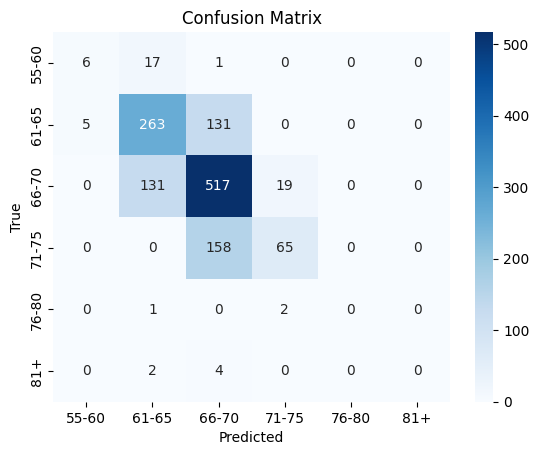

In [6]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

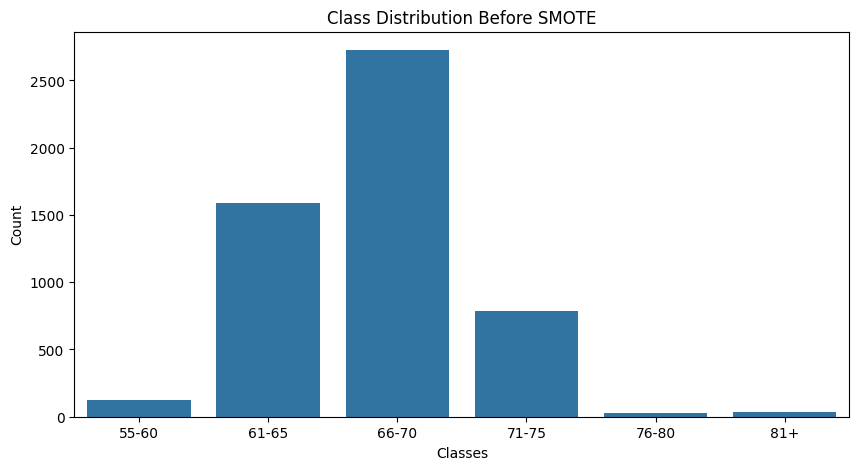

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Before SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train, order=ordered_classes)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [7]:
# Step 7: Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Step 8: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Step 9: Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Use KNeighborsClassifier for classification
knn.fit(X_train, y_train)

# Step 10: Make predictions
y_pred = knn.predict(X_test)
# Optional: Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 21)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

print(f"Best number of neighbors: {grid.best_params_}")

Best number of neighbors: {'n_neighbors': 1}


In [8]:
# Step 8: Train the KNN model for classification
knn = KNeighborsClassifier(n_neighbors=5)

# Define custom scorers
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr', response_method='predict_proba')
}

# Perform cross-validation
cv_results = cross_validate(knn, X_train, y_train, cv=5, scoring=scorers)

# Calculate metrics
metrics = {
    "Accuracy": (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
    "Precision": (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
    "Recall": (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
    "F1": (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
    "AUC": (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
}

# Step 9: Display metrics
print("\nKNN Metrics:")
for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")

# Train the model
knn.fit(X_train, y_train)

# Step 9: Make predictions
y_pred = knn.predict(X_test)

# Classification report
print("\nClassification Report After Balancing:")
print(classification_report(y_test, y_pred, zero_division=1))

# Accuracy score for test data
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.4f}")



KNN Metrics:
Accuracy: Mean = 0.8455, Std = 0.0043
Precision: Mean = 0.8406, Std = 0.0068
Recall: Mean = 0.8455, Std = 0.0043
F1: Mean = 0.8303, Std = 0.0044
AUC: Mean = 0.9673, Std = 0.0007

Classification Report After Balancing:
              precision    recall  f1-score   support

       55-60       0.88      1.00      0.94       656
       61-65       0.76      0.76      0.76       733
       66-70       0.75      0.40      0.52       635
       71-75       0.81      0.94      0.87       664
       76-80       0.98      1.00      0.99       715
         81+       0.90      1.00      0.95       669

    accuracy                           0.85      4072
   macro avg       0.85      0.85      0.84      4072
weighted avg       0.85      0.85      0.84      4072


Test Set Accuracy: 0.8546


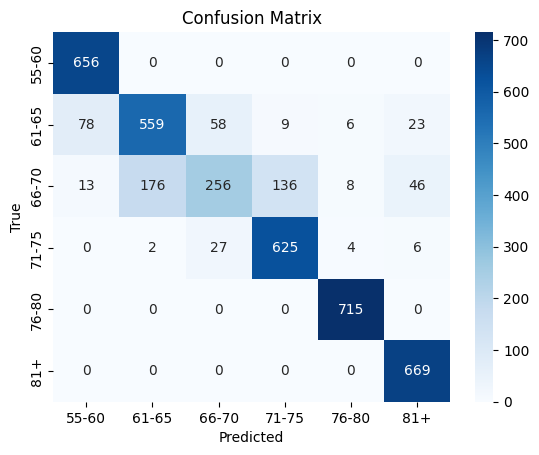

In [9]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

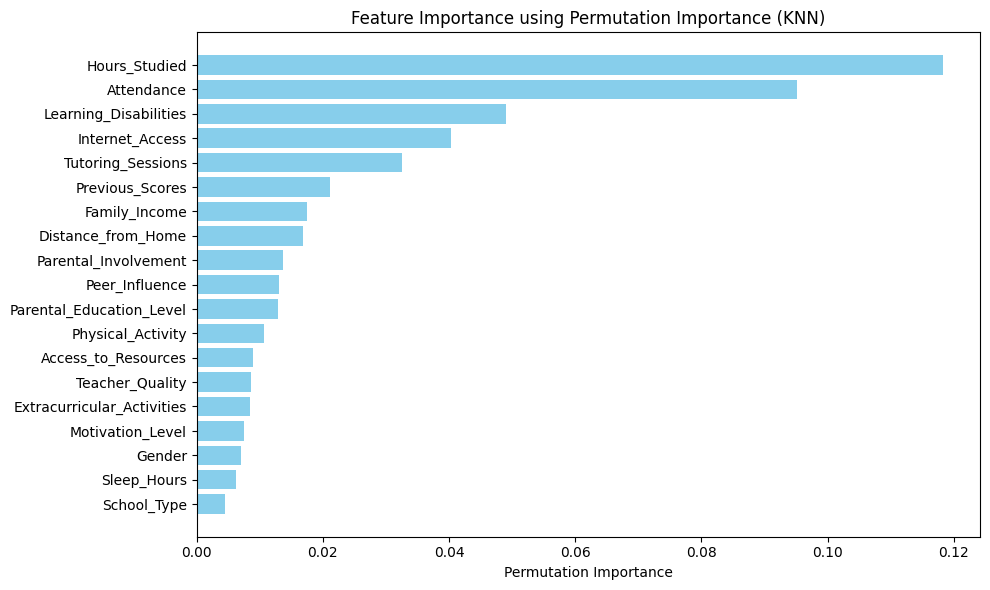

In [25]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

# Step 2: Perform permutation importance on the trained model
# For this, we'll use the test set (X_test, y_test)
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)

# Step 3: Get the feature importances
importance = result.importances_mean
std = result.importances_std

# Step 4: Create a bar chart to visualize feature importance
features = X.columns  # Assuming X is the original dataframe with feature names

# Sorting features by importance
sorted_idx = np.argsort(importance)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importance[sorted_idx], color='skyblue', align='center')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance using Permutation Importance (KNN)')
plt.tight_layout()
plt.show()


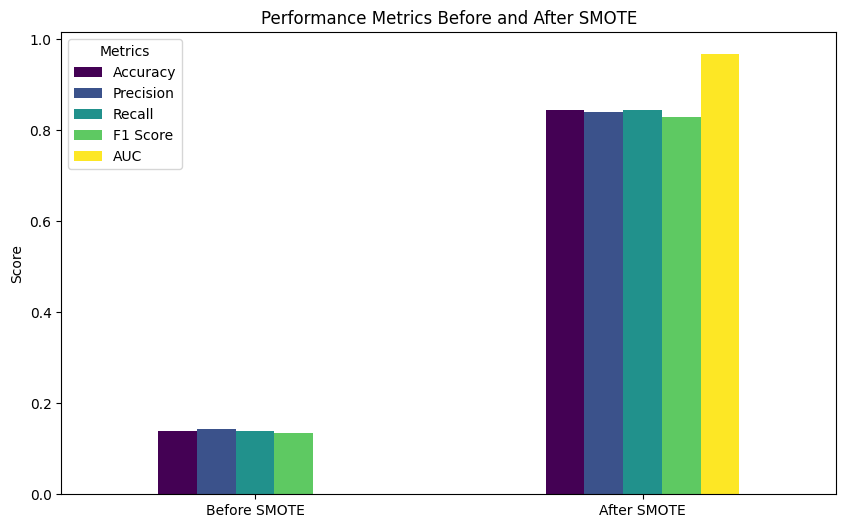

In [26]:
metrics = {
    "Accuracy": [0.1389, 0.8455],
    "Precision": [0.1431, 0.8406],
    "Recall": [0.1389, 0.8455],
    "F1 Score": [0.1347, 0.8303],
    "AUC": [None, 0.9673]
}

import pandas as pd
metrics_df = pd.DataFrame(metrics, index=["Before SMOTE", "After SMOTE"])

metrics_df.plot(kind='bar', figsize=(10, 6), colormap="viridis")
plt.title("Performance Metrics Before and After SMOTE")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.show()


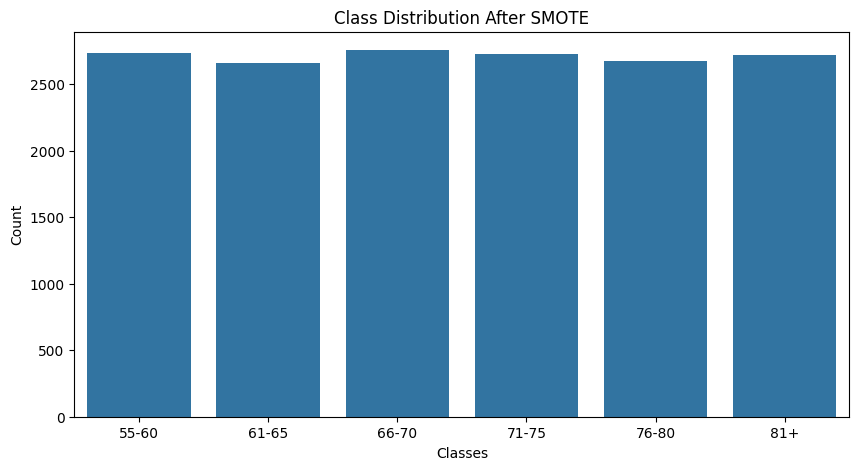

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# After SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train, order=ordered_classes)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()
